In [1]:
import sys
sys.path.insert(0, '../../')

In [2]:
import torch as t
import numpy as np
from experiment_helper import chop_and_shuffle_data, generate_sequence
from diffusion_gumbel import diffuse_STE
from reaction_diff import rho_STE
from tqdm import tqdm
import matplotlib.pyplot as plt
import os 
from os import path, getcwd
import time
import imageio
import random

In [3]:
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
data_dir = path.join(getcwd(), "data", "1675164571.9021132")
ref_state = t.load(path.join(data_dir, "batch_500", "0.pt"), map_location=device)

torch.Size([2, 64, 64])


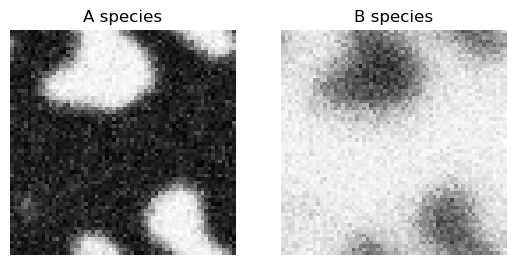

In [5]:
print(ref_state.shape)
fig, axs = plt.subplots(1,2)
axs[0].imshow(ref_state[0].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[0].set_title("A species")
axs[0].axis("off")
axs[1].imshow(ref_state[1].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[1].set_title("B species")
axs[1].axis("off")
plt.show()

In [6]:
def loss_fn(X, Y):
    return t.log(t.sum((X[:, 0] - Y[:,0])**2 + (X[:, 1] - Y[:,1])**2, dim=(0,1,2)))

In [7]:
from torch.distributions import uniform
param_sampler = uniform.Uniform(0,1)

k1 = param_sampler.sample().to(device)
k2 = param_sampler.sample().to(device)
k3 = param_sampler.sample().to(device)
DB = param_sampler.sample().to(device)
DA = param_sampler.sample().to(device)

In [10]:
gamma = 0.005
N = 50

if ref_state.ndim == 3:
    ref_state = ref_state.unsqueeze(0)

k1_vals = [k1.detach().cpu().numpy()]
k2_vals = [k2.detach().cpu().numpy()]
k3_vals = [k3.detach().cpu().numpy()]
DB_vals = [DB.detach().cpu().numpy()]
DA_vals = [DA.detach().cpu().numpy()]
losses = []
grads_k1 = []
grads_k2 = []
grads_k3 = []
grads_DB = []
grads_DA = []

In [11]:
for i in tqdm(range(5_000)):
    X = ref_state.detach().clone()
    
    k1.requires_grad_()
    k2.requires_grad_()
    k3.requires_grad_()
    DB.requires_grad_()
    DA.requires_grad_()
    
    # Make predictions for this batch
    for sim_step in range(500):
        # run the diffusion step
        X = diffuse_STE(X, N, DA, DB)
        # run the reaction step
        X = rho_STE(X, N, gamma, k1, k1, k2, k2, k3, k3)
        
    # Compute the loss and its gradients
    loss = loss_fn(ref_state, X)
    grad_k1, grad_k2, grad_k3, grad_DB, grad_DA = t.autograd.grad(loss, (k1, k2, k3, DB, DA))

    k1 = k1 - 0.1 * grad_k1
    k2 = k2 - 0.001 * grad_k2
    k3 = k3 - 0.01 * grad_k3
    DB = DB - 0.01 * grad_DB
    DA = DA - 0.01 * grad_DA
            
    with t.no_grad():
        k1 = k1.clamp(0, 1)
        k2 = k2.clamp(0, 1)
        k3 = k3.clamp(0, 1)
        DB = DB.clamp(0, 1)
        DA = DA.clamp(0, 1)
    
    k1_vals.append(k1.detach().cpu().numpy())
    k2_vals.append(k2.detach().cpu().numpy())
    k3_vals.append(k3.detach().cpu().numpy())
    DB_vals.append(DB.detach().cpu().numpy())
    DA_vals.append(DA.detach().cpu().numpy())
    losses.append(loss.detach().cpu().numpy())
    grads_k1.append(grad_k1.detach().cpu().numpy())
    grads_k2.append(grad_k2.detach().cpu().numpy())
    grads_k3.append(grad_k3.detach().cpu().numpy())
    grads_DB.append(grad_DB.detach().cpu().numpy())
    grads_DA.append(grad_DA.detach().cpu().numpy())

100%|██████████| 5000/5000 [10:40:22<00:00,  7.68s/it] 


In [15]:
len(k1_vals)

5001

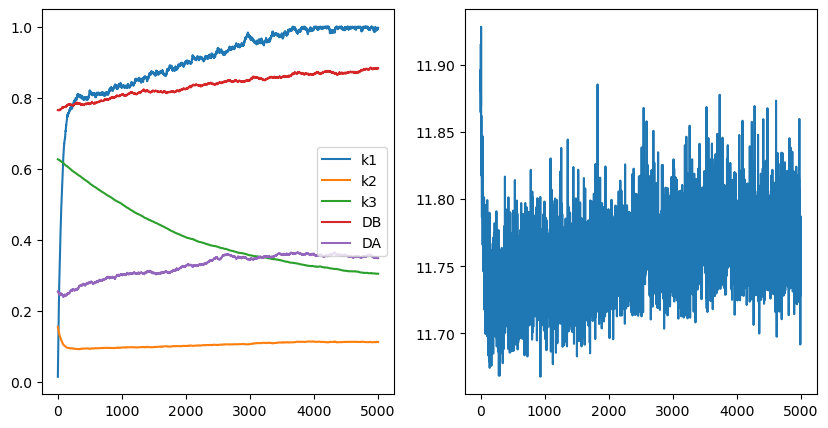

In [19]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

num_steps = 5000
steprange = np.arange(num_steps+1)

axs[0].plot(steprange, k1_vals, label="k1")
axs[0].plot(steprange, k2_vals, label="k2")
axs[0].plot(steprange, k3_vals, label="k3")
axs[0].plot(steprange, DB_vals, label="DB")
axs[0].plot(steprange, DA_vals, label="DA")

axs[1].plot(np.arange(num_steps), losses)

axs[0].legend()
plt.show()

Text(0.5, 0, 'step')

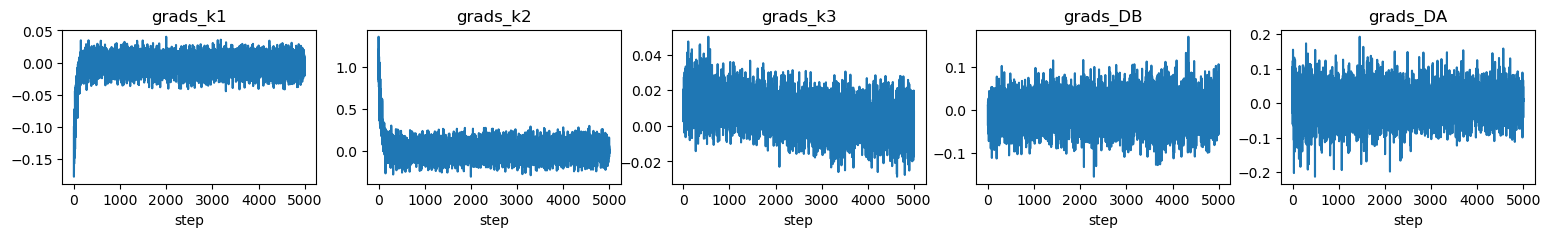

In [27]:
fig, axs = plt.subplots(1, 5, figsize=(19,2))

axs[0].plot(np.arange(num_steps), grads_k1)
axs[0].set_title("grads_k1")
axs[0].set_xlabel("step")

axs[1].plot(np.arange(num_steps), grads_k2)
axs[1].set_title("grads_k2")
axs[1].set_xlabel("step")

axs[2].plot(np.arange(num_steps), grads_k3)
axs[2].set_title("grads_k3")
axs[2].set_xlabel("step")

axs[3].plot(np.arange(num_steps), grads_DB)
axs[3].set_title("grads_DB")
axs[3].set_xlabel("step")

axs[4].plot(np.arange(num_steps), grads_DA)
axs[4].set_title("grads_DA")
axs[4].set_xlabel("step")

In [31]:
for i in range(0, num_steps, 50):
    k1 = t.tensor(k1_vals[i], device=device)
    k2 = t.tensor(k2_vals[i], device=device)
    k3 = t.tensor(k3_vals[i], device=device)
    DA = t.tensor(DA_vals[i], device=device)
    DB = t.tensor(DB_vals[i], device=device)
    
    X = t.zeros((1, 2, 64, 64), device=device)
    X[:] = 25
    X[0, 29:35] = 40
    
    for j in tqdm(range(50_000)):
        # run the diffusion step
        X = diffuse_STE(X, N, DA, DB)
        # run the reaction step
        X = rho_STE(X, N, gamma, k1, k1, k2, k2, k3, k3)
    
    np.save(f"./data/inference/{i}.npy", X.cpu().numpy())

100%|██████████| 50000/50000 [05:01<00:00, 165.96it/s]
